<a href="https://colab.research.google.com/github/Jeonyujeong/RottenFruitsModel/blob/master/ResNet50_rotten_cherry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 학습 결과

```
[INFO] evaluating network...
                  precision    recall  f1-score   support

          damage       0.68      0.80      0.74        66
          normal       0.81      0.72      0.77        79
spoiled_advanced       0.75      0.97      0.85        62
   spoiled_early       0.88      0.59      0.71        64

        accuracy                           0.77       271
       macro avg       0.78      0.77      0.76       271
    weighted avg       0.78      0.77      0.76       271

```

In [ ]:
!wget https://github.com/RottenFruitsOSS/DataSet/raw/master/dataset_count_fit.tar.gz

--2020-08-26 06:25:15--  https://github.com/RottenFruitsOSS/DataSet/raw/master/dataset_count_fit.tar.gz
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/RottenFruitsOSS/DataSet/master/dataset_count_fit.tar.gz [following]
--2020-08-26 06:25:16--  https://raw.githubusercontent.com/RottenFruitsOSS/DataSet/master/dataset_count_fit.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6198630 (5.9M) [application/octet-stream]
Saving to: ‘dataset_count_fit.tar.gz’

dataset_count_fit.t 100%[===================>]   5.91M  24.2MB/s    in 0.2s    

2020-08-26 06:25:16 (24.2 MB/s) - ‘dataset_count_fit.tar.gz’ s

In [ ]:
!tar -xvzf dataset_count_fit.tar.gz

In [ ]:
%%shell

mkdir dataset
mv test_classification/ dataset/
mv train_classification/ dataset/

In [ ]:
# import the necessary packages
import os

# initialize the path to the input directory containing our dataset
# of images
DATASET_PATH = "dataset"

# initialize the class labels in the dataset
CLASSES = ["damage", "normal", "spoiled_advanced", "spoiled_early"]
# CLASSES = ["normal", "spoiled_early"]

# define the size of the training, validation (which comes from the
# train split), and testing splits, respectively
TRAIN_SPLIT = 0.75
VAL_SPLIT = 0.1
TEST_SPLIT = 0.25

# define the minimum learning rate, maximum learning rate, batch size,
# step size, CLR method, and number of epochs
BATCH_SIZE = 32
STEP_SIZE = 8
NUM_EPOCHS = 60

# set the path to the serialized model after training
MODEL_PATH = os.path.sep.join(["output", "rotten_cherry.model"])


In [ ]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
# matplotlib.use("Agg")

# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import pickle
import cv2
import sys
import os

In [ ]:
def load_dataset(datasetPath):
    # grab the paths to all images in our dataset directory and initialize
    # our lists of images and class labels
    imagePaths = list(paths.list_images(datasetPath))
    data = []
    labels = []

    # loop over the image paths
    for imagePath in imagePaths:
        # extract the class label
        label = imagePath.split(os.path.sep)[-2]

        # load the image, convert it to RGB channel ordering, and resize
        # it to be a fixed 224x224 pixels, ignoring aspect ratio
        image = cv2.imread(imagePath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (224, 224))
        # update the data and labels lists, respectively

        data.append(image)
        labels.append(label)

    # convert the data and labels to NumPy arrays
    return np.array(data, dtype="float32"), np.array(labels)

[INFO] processing data...
(1084, 224, 224, 3)


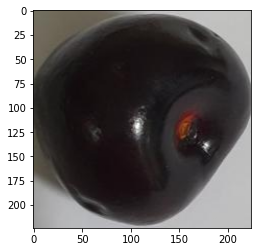

In [ ]:
print("[INFO] processing data...")
data, labels_ = load_dataset(DATASET_PATH)
 
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels_)

print(data.shape)
# print(labels_)
# print(labels)

plt.imshow(data[0]/255)
plt.show()

In [ ]:
# TRAIN_SPLIT = 0.75
# VAL_SPLIT = 0.1
# TEST_SPLIT = 0.25

# partition the data into training and testing splits
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=TEST_SPLIT, random_state=42)

# take the validation split from the training split
(trainX, valX, trainY, valY) = train_test_split(trainX, trainY,
	test_size=VAL_SPLIT, random_state=84)

# initialize the training data augmentation object
aug = ImageDataGenerator(
	rotation_range=30,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

In [ ]:
# ImageNet 데이터 셋에서 사전 학습된 VGG16 모델 조정함.

# load the VGG16 network, ensuring the head FC layer sets are left
# off
baseModel = ResNet50(weights='imagenet', include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# baseModel = VGG16(weights="imagenet", include_top=False,
# 	input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(len(CLASSES), activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False
	
# compile our model (this needs to be done after our setting our
# layers to being non-trainable
print("[INFO] compiling model...")
# opt = SGD(lr=MIN_LR, momentum=0.9)
model.compile(loss="categorical_crossentropy", optimizer='adam',
	metrics=["accuracy"])

[INFO] compiling model...


In [ ]:
stepSize = STEP_SIZE * (trainX.shape[0] // BATCH_SIZE)

# train the network
print("[INFO] training network...")
H = model.fit_generator(
	aug.flow(trainX, trainY, batch_size=BATCH_SIZE),
	validation_data=(valX, valY),
	steps_per_epoch=trainX.shape[0] // BATCH_SIZE,
	epochs=NUM_EPOCHS,
	verbose=1)

[INFO] training network...
Epoch 1/60
22/22 [==============================] - 9s 395ms/step - loss: 24.9151 - accuracy: 0.3906 - val_loss: 6.2424 - val_accuracy: 0.5366
Epoch 2/60
22/22 [==============================] - 8s 357ms/step - loss: 4.9303 - accuracy: 0.5737 - val_loss: 1.1887 - val_accuracy: 0.6220
Epoch 3/60
22/22 [==============================] - 8s 359ms/step - loss: 1.8045 - accuracy: 0.4993 - val_loss: 1.1934 - val_accuracy: 0.4634
Epoch 4/60
22/22 [==============================] - 8s 360ms/step - loss: 1.1952 - accuracy: 0.4964 - val_loss: 1.0178 - val_accuracy: 0.5732
Epoch 5/60
22/22 [==============================] - 8s 361ms/step - loss: 1.1390 - accuracy: 0.4778 - val_loss: 0.9730 - val_accuracy: 0.5976
Epoch 6/60
22/22 [==============================] - 8s 362ms/step - loss: 1.1940 - accuracy: 0.4878 - val_loss: 0.8738 - val_accuracy: 0.6585
Epoch 7/60
22/22 [==============================] - 8s 359ms/step - loss: 1.0986 - accuracy: 0.5508 - val_loss: 0.8173 -

In [ ]:
# evaluate the network and show a classification report
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=BATCH_SIZE)
print(classification_report(testY.argmax(axis=1),
	predictions.argmax(axis=1), target_names=CLASSES))

# serialize the model to disk
# print("[INFO] serializing network to '{}'...".format(MODEL_PATH))
# model.save(MODEL_PATH)

[INFO] evaluating network...
                  precision    recall  f1-score   support

          damage       0.63      0.79      0.70        66
          normal       0.80      0.84      0.81        79
spoiled_advanced       0.80      0.92      0.86        62
   spoiled_early       0.97      0.53      0.69        64

        accuracy                           0.77       271
       macro avg       0.80      0.77      0.77       271
    weighted avg       0.80      0.77      0.77       271

[INFO] serializing network to 'output/rotten_cherry.model'...


KeyboardInterrupt: ignored

In [ ]:
from tensorflow.keras.models import load_model
from imutils import paths
from IPython.display import Image
import numpy as np
import imutils
import random
import cv2
import os
import matplotlib.pyplot as plt
from IPython.display import Image, display
from google.colab.patches import cv2_imshow

MODEL_PATH = "/content/output/rotten_cherry.model"
SAMPLE_SIZE = 5
OUTPUT_IMAGE_PATH = "output/images"

[INFO] loading model...
[INFO] predicting...
['dataset/train_classification/spoiled_early/early_1146.jpg', 'dataset/test_classification/damage/damage_131.jpg', 'dataset/train_classification/spoiled_early/early_27.jpg', 'dataset/train_classification/normal/P_normal_658.jpg', 'dataset/train_classification/damage/demage_200.jpg']
output/images


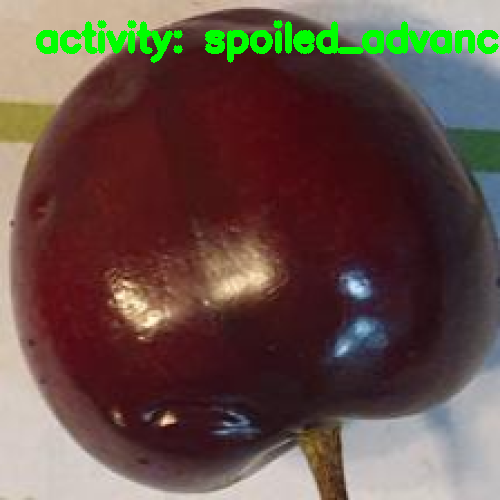

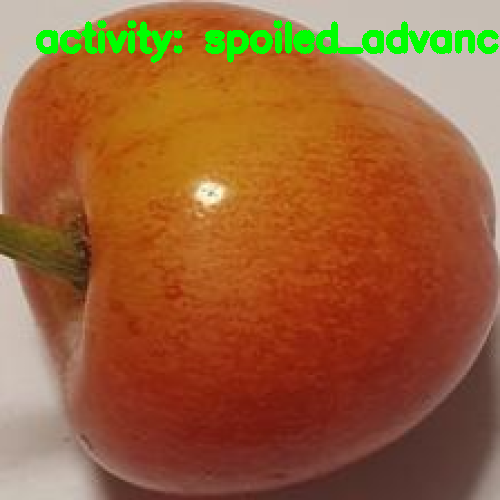

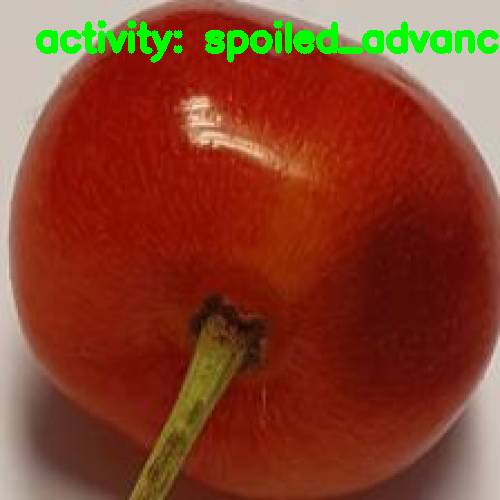

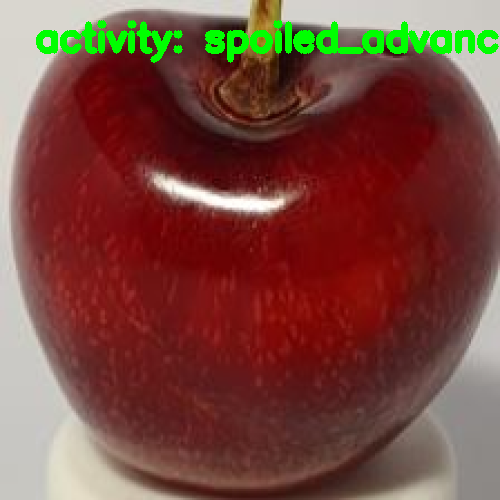

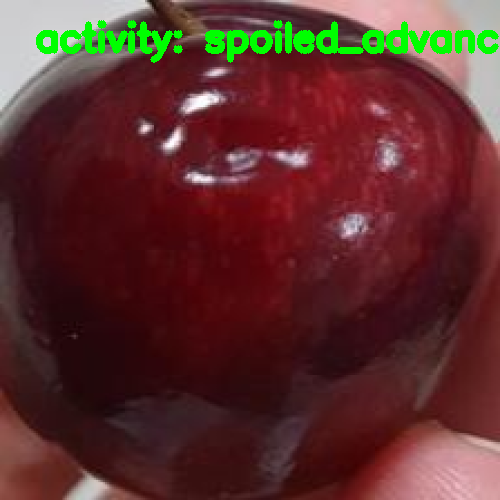

In [ ]:
# load the trained model from disk
print("[INFO] loading model...")
model = load_model(MODEL_PATH)

# grab the paths to the disaster images, respectively
print("[INFO] predicting...")
imagePaths = list(paths.list_images(DATASET_PATH))

# combine the two image path lists, randomly shuffle them, and sample
# them
random.shuffle(imagePaths)
imagePaths = imagePaths[:SAMPLE_SIZE]
print(imagePaths)
print(OUTPUT_IMAGE_PATH)

# loop over the sampled image paths
for (i, imagePath) in enumerate(imagePaths):
	# load the image and clone it
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (224, 224))
    output = image.copy()
 
	# resize the input image to be a fixed 128x128 pixels, ignoring
	# aspect ratio
    image = cv2.resize(image, (224, 224))
    image = image.astype("float32") / 255.0
		
	# make predictions on the image
    preds = model.predict(np.expand_dims(image, axis=0))[0]
    j = np.argmax(preds)
    label = CLASSES[j]

	# draw the activity on the output frame
    text = "activity: {}".format(label)
    output = imutils.resize(output, width=500)
    cv2.putText(output, text, (35, 50), cv2.FONT_HERSHEY_SIMPLEX,
		1.25, (0, 255, 0), 5)

	# write the output image to disk	 
    filename = "{}.png".format(i)
    p = os.path.sep.join([OUTPUT_IMAGE_PATH, filename])
    cv2_imshow(output)
    # cv2.imwrite(p, output)